In this notebook, I will use the dataset for the wine quality to cover the following aspects of machine learning :
- Feature engineering 
- Correlation analysis
- Deal with outliers
- Hyper parameters grid search for the different models

Regarding the model selection, three types of classifiers (Logistic Regression, Random Forest and KNN) will be tested and the best one will be chosen based on the F1 score.

Let's start by uploading the required packages.

PS: Don't forget to upvote if you like the content.

In [1]:
#Importing required packages.
import numpy as np
import pandas as pd
import seaborn as sns
from prettytable import PrettyTable
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score
import warnings
warnings.filterwarnings('ignore')

Now we load the data in a pandas dataframe

In [2]:
wine_data = pd.read_csv('/kaggle/input/red-wine-quality-cortez-et-al-2009/winequality-red.csv')

It is a good habit to take a look at some of the data. Let's look at some random rows from the dataset.

In [3]:
wine_data.sample(10)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
1073,8.0,0.62,0.33,2.7,0.088,16.0,37.0,0.99720,3.31,0.58,10.7,6
661,7.5,0.42,0.31,1.6,0.080,15.0,42.0,0.99780,3.31,0.64,9.0,5
671,8.2,0.73,0.21,1.7,0.074,5.0,13.0,0.99680,3.20,0.52,9.5,5
1242,9.0,0.40,0.41,2.0,0.058,15.0,40.0,0.99414,3.22,0.60,12.2,6
360,8.2,0.70,0.23,2.0,0.099,14.0,81.0,0.99730,3.19,0.70,9.4,5
668,10.0,0.73,0.43,2.3,0.059,15.0,31.0,0.99660,3.15,0.57,11.0,5
726,8.1,0.72,0.09,2.8,0.084,18.0,49.0,0.99940,3.43,0.72,11.1,6
1107,9.1,0.30,0.41,2.0,0.068,10.0,24.0,0.99523,3.27,0.85,11.7,7
1162,8.5,0.32,0.42,2.3,0.075,12.0,19.0,0.99434,3.14,0.71,11.8,7
824,7.1,0.48,0.28,2.8,0.068,6.0,16.0,0.99682,3.24,0.53,10.3,5


Based on that little glimpse the data look fine. Now we need to see if there is any missing values (NaN, Null,...). The next step would be to do exploratory data analysis (EDA).

**Exploratory data analysis (EDA)**

The first step is to check the basic statistics about the data.

In [4]:
wine_data.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


Based on the results of the "describe()" fucntion, we are able to make the following remarks: 
- The numbers of samples is the same for all the features so there is no missing values in the dataset. 
- If we analyze the mean and the 50% percentile, we can tell that some distrubtions are skewed (for example: 'fixed acidity', 'residual sugar',...)
- The max value for some features are way bigger that the 75% percentile which suggest that the dataset contains some outliers that we need to get rid off to have a better model.

To tackle that last remarks, we can use the Z-Score to remove the rows that contains outliers. The threshold for the Z-Score will be 3 (any observation that has a Z-Score above 3 then it will be removed from the dataset).

In [5]:
#Z-Score calculations
z_scores = zscore(wine_data)

#Creating a new DataFrame where the outliers have been removed.
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
wine_data_wo_outliers = wine_data[filtered_entries]

wine_data_wo_outliers.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1451.000000,1451.000000,1451.000000,1451.000000,1451.000000,1451.000000,1451.000000,1451.000000,1451.000000,1451.000000,1451.000000,1451.000000
mean,8.310062,0.522950,0.265382,2.387285,0.081425,15.104755,43.735355,0.996710,3.315934,0.642584,10.421089,5.659545
std,1.646458,0.168531,0.190934,0.862078,0.020966,9.309768,29.441284,0.001716,0.141096,0.129801,1.021588,0.781605
min,5.000000,0.120000,0.000000,1.200000,0.038000,1.000000,6.000000,0.991500,2.880000,0.330000,8.500000,4.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,21.000000,0.995600,3.220000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.250000,2.200000,0.079000,13.000000,36.000000,0.996700,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.630000,0.420000,2.600000,0.089000,21.000000,58.000000,0.997800,3.400000,0.720000,11.100000,6.000000
max,13.500000,1.040000,0.790000,6.700000,0.226000,47.000000,145.000000,1.002200,3.750000,1.160000,13.600000,8.000000


We see that the outliers have been removed since the difference between the max value and the 75% percentile are not as big as befire. Let's see how many rows have been removed from the original dataset.

In [6]:
print("The original dataset has %i rows" %wine_data.shape[0])
print("The new (without outliers) dataset has %i rows" %wine_data_wo_outliers.shape[0])

The original dataset has 1599 rows
The new (without outliers) dataset has 1451 rows


About 10 percent of the dataset was removed so not a lot of data have been lost. If we had removed more than 20% of the data then we would have used another strategy to deal with outliers than the Z-Score. Now let's look at the correlation matrix between the different features. 

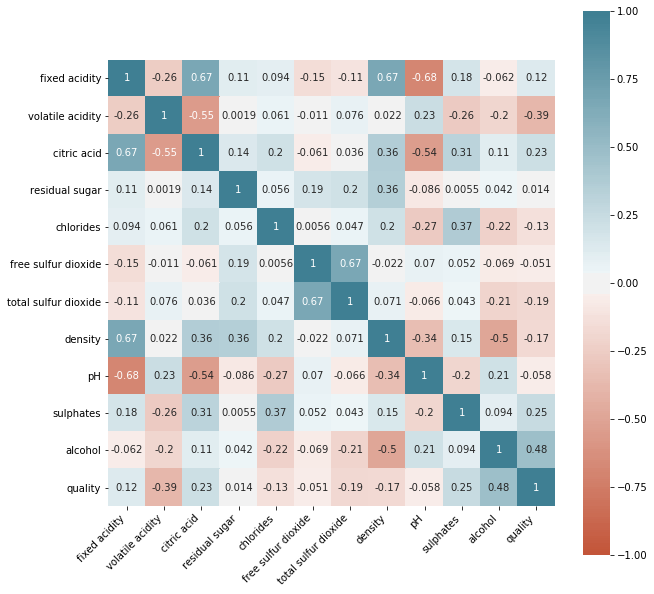

In [7]:
corr = wine_data.corr()
plt.figure(figsize=(10,10))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot = True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

The correlation matrix could be a very good tool to have a quantitative model that gives a high level model between the different features. Based on the correlation matrix, we can start doing some deductions based on the correlation factors :

- We can see how the "ph" is affected by the inputs the have fixed acidity and citric acid (-0.68 and -0.54 respectively) which is normal. If there is more acid then the value of the pH will decrease and vice versa. The value of the 'pH' is positively affected if you increase the value of the volatile acide. Again it is normal to see that because the volatile acidity is an acidity that does not exist in the wine anymore.
- The quality is positively affected by the alcohol so the more you have the better. But you have a lot of volatile acidity then it will decrease the quality
- The quality of the wine is mainly correlated to "fixed acidity", "volatile acidity", "citric acid", "sulphates" and "alcohol".

Before getting to the model selection, we will create a new feature called "class" that will have two category. The first are for the "Bad Wines" where the "quaity" is below 7. The second category is for the "Good Wine" where the "quality" above 7. Creating that new feature will alow us to transform to a binary classification problem.

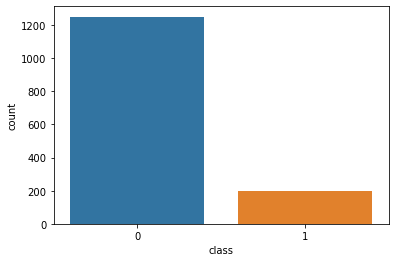

In [8]:
# Create a new column called "class" and it will be equal to 1
# if the quality is greater or equal to 7 otherwise it will be 0
wine_data_wo_outliers['class'] = np.where(wine_data_wo_outliers['quality']>=7, 1, 0)
sns.countplot(wine_data_wo_outliers['class']);

the new created variable is the one that will be predicted by the classifier that will be developed. Now let's look at how imbalanced the variable class this will allow us to decide how to assess the performance of the classifier. We can use Accuracy to assess the performance of the classifier if the dataset is fairly, otherwise the F1 Score will be more appropriate. 

we can tell that the dataset in imbalanced and we will use the accuray and the f1 score to assess the performance of the models

**Model Selection**

In [9]:
#Now seperate the dataset as response variable and feature variabes
X = wine_data_wo_outliers.drop(['quality', 'class'], axis = 1)
y = wine_data_wo_outliers['class']

#Train and Test splitting of data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

#Applying Standard scaling to get optimized result
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

Now that we have split the data to training and testing datasets. We can start testing the models and decide to get the best model. One of the things that we need to decide before selecting the best model is to decide what would be the best way to assess the performance of the models.

**Model selection**

Since we can have created a new variable called "Class" containing two categories then the model will be a classifier. One of the most popular ways to assess the performance of a classifier is to use accuracy. In our case, the accuracy is not a suitable performance assesser since the variable "Class" is unbalanced. To illustrate that, let's assume that we have a classifier that define all the wines as bad ones (Class equal 0) the it means that the acccuracy in that case would be:
accuracy = number of good predictions/number of samples in the data set
accuracy = 1450/1500 = 86%'

In that case using the accuracy to assess the performance of a classifier is not a good idea. Instead, we will use the f1 score that is a combination of the precision and the recall. Using the f1 score, we will see how many good wines that have been classified as bad ones and vice versa.

precision depends of the false positive (wine that is bad but predicted as good) : It will affect the reputation of the seller
recall depends on the false negatives (wine that good but predicted as bad) : It will affect the financial benefits since it will be price-tagged as bad wine and not good

In this case, both the precision and recall are important criterias and this is why we will use the f1 score which is a combination of the two metrics (precision and recall).

The classifiers that will be tested are Logostic Regression, Random Forest, SVC and KNN. For each of those classifiers a grid search will be conduct to find the best set of hyper parameters that give the optimal results.

**Logistic Regression**

In [10]:

param_lr = {'penalty': ['l1', 'l2', 'elasticnet’, ‘none'], 
            'C':[0.001,.009,0.01,.09,1,5,10,25], 
            'max_iter':[1, 10, 100]}
grid_search_lr = GridSearchCV(LogisticRegression(random_state=42), 
                       cv=3 , 
                       param_grid = param_lr,
                       scoring = 'f1');
grid_search_lr.fit(X_train, y_train)

#Predict values based on new parameters
y_pred_lr = grid_search_lr.predict(X_test)

accuracy_score_lr = accuracy_score(y_test,y_pred_lr)
f1_score_lr = f1_score(y_test,y_pred_lr)

# New Model Evaluation metrics
print('Best parameters for the Logisitic Regression:')
print(grid_search_lr.best_params_)
print('The accuracy score : ' + str(accuracy_score_lr))
print('The f1 score : ' + str(f1_score_lr))

Best parameters for the Logisitic Regression:
{'C': 0.001, 'max_iter': 1, 'penalty': 'l2'}
The accuracy score : 0.845360824742268
The f1 score : 0.5454545454545455


Now that we have the best set of results for the Logistic Regression. Let's see an important feature that is "Feature Importance". It gives for the importance of each feature in the developped LR model.

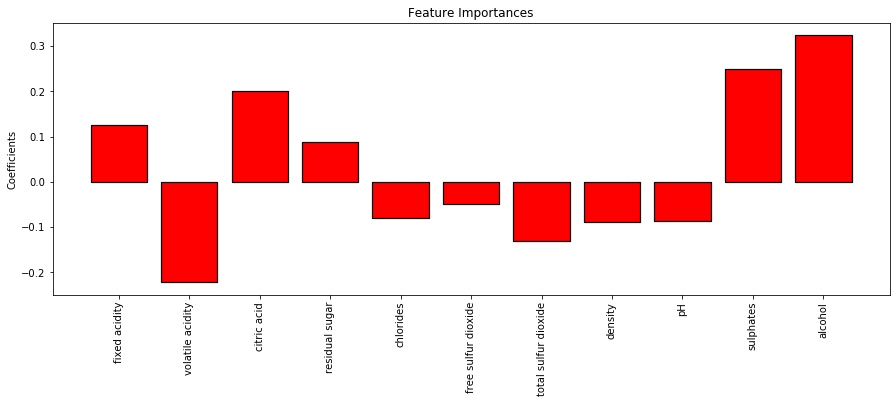

In [11]:
feature_list = list(wine_data_wo_outliers.columns)

# Get numerical feature importances
importances = list(grid_search_lr.best_estimator_.coef_[0])

# list of x locations for plotting
x_values = list(range(len(importances)))

plt.figure(figsize=(15,5))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical', color = 'r', edgecolor = 'k', linewidth = 1.2)
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Coefficients'); plt.title('Feature Importances');

With the logistic regression, the higher value of the coefficient the more important it is. As we can see from the graph, the three features that have the more effect on the classe of the wine are "alcohol", "sulphates" and "citric acid".

The second model to test is the Random Forest.

In [12]:
# Create the parameter grid based on the results of random search 
param_rf = {
    'max_depth': [20,30,40, 80, 90, 100],
    'n_estimators': [10, 50, 100, 200]
}

# Instantiate the grid search model
grid_search_rf = GridSearchCV(RandomForestClassifier(bootstrap = True), 
                              param_grid = param_rf, 
                              cv = 3, 
                              scoring = 'f1')
grid_search_rf.fit(X_train, y_train)

y_pred_rf = grid_search_rf.predict(X_test)

accuracy_score_rf = accuracy_score(y_test,y_pred_rf)
f1_score_rf = f1_score(y_test,y_pred_rf)

print('Best parameters for the Logisitic Regression:')
print(grid_search_rf.best_params_)
print('Accuracy Score : ' + str(accuracy_score_rf))
print('F1 Score : ' + str(f1_score_rf))

Best parameters for the Logisitic Regression:
{'max_depth': 100, 'n_estimators': 200}
Accuracy Score : 0.9072164948453608
F1 Score : 0.6086956521739131


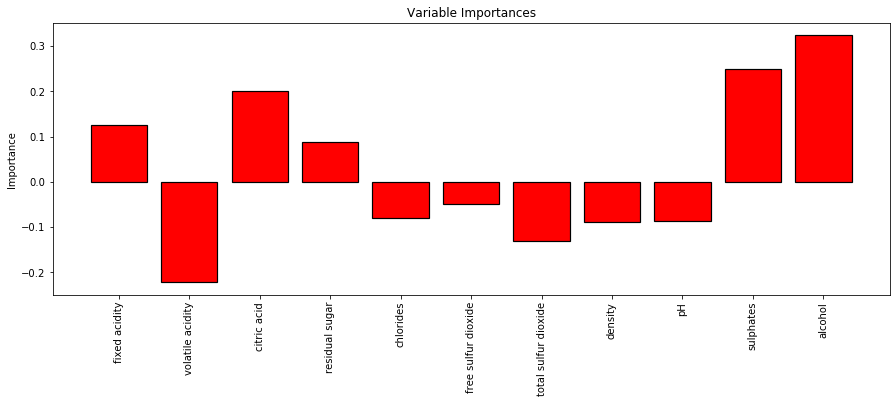

In [13]:
# list of x locations for plotting
x_values = list(range(len(importances)))

plt.figure(figsize=(15,5))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical', color = 'r', edgecolor = 'k', linewidth = 1.2)
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.title('Variable Importances');

KNN model

In [24]:

param_knn = {'weights': ['uniform', 'distance'],
             'n_neighbors':[1, 5, 10, 20, 30]}
grid_search_knn = GridSearchCV(KNeighborsClassifier(), 
                        cv=3, 
                        param_grid = param_knn,
                        scoring = 'f1');

grid_search_knn.fit(X_train, y_train)
y_pred_knn = grid_search_knn.predict(X_test)

accuracy_score_knn = accuracy_score(y_test,y_pred_knn)
f1_score_knn = f1_score(y_test,y_pred_knn)

# New Model Evaluation metrics 
print('Best parameters for the KNN:')
print(grid_search_knn.best_params_)
print('Accuracy Score : %3.2f' %(accuracy_score_knn))
print('F1 Score : %3.2f' %(f1_score_knn))

Best parameters for the KNN:
{'n_neighbors': 10, 'weights': 'distance'}
Accuracy Score : 0.91
F1 Score : 0.63


Unfortunately, the KNN does not have a feature importance method that we can use. Now let's put all the results for each type of classifier in a table.

**Summary**

To summarize the performance of the four tested models.

In [21]:
x = PrettyTable()

x.field_names = ["Model", "F1 Score", "Accuracy"]
x.add_row(["Logistic Regression", '{:0.2f}'.format(f1_score_lr), '{:0.2f}'.format(accuracy_score_lr)])
x.add_row(["Random Forest", '{:0.2f}'.format(f1_score_rf), '{:0.2f}'.format(accuracy_score_rf)])
x.add_row(["KNN", '{:0.2f}'.format(f1_score_knn), '{:0.2f}'.format(accuracy_score_knn)])

print(x)

+---------------------+----------+----------+
|        Model        | F1 Score | Accuracy |
+---------------------+----------+----------+
| Logistic Regression |   0.55   |   0.85   |
|    Random Forest    |   0.61   |   0.91   |
|         KNN         |   0.63   |   0.91   |
+---------------------+----------+----------+
